In [110]:
# Theory
#1) Moving Averages, Neural Networks, and Autoregressive Integrated Moving Average. 

#2)The Weather and Stock Market are two real world examples of where time series forecasting can be used. 

#3) Time series data is focusing on one variable over time while panel series is focusing on multiple variables. 

#4) When selecting training sets in time series machine learning, it must be in order of date as you should select
# previous time/dates to predict the future ones while in regular regression, the order you pick your training set 
# in does not matter too much. 

#5) Stationary- It has no predictable pattern in the long term
# Differencing- a process used to make the data stationary
# White Noise- a series of observations that are independently and identically distributed with a mean of 0 
# and constant variance. 
# Random Walk- a series of observations where the current observation equals to the previous observation with 
# a random step up and down

#6)a) 𝜙 is the coefficent for AR
#c is a constant 
# θ is the MA coefficient
# epsilon(t) is a white noise coefficent, a usually a normal random variable
# epsilon(t-1) is also a white noise coefficent, a usually a normal random variable

# b) Since its an ARMA model not ARIMA model, it does not have the I which tells the level it has been differenced. So we can not tell if it has been differenced. 

#c) The moving average order for this is 4. The AR order is 3. 

#d) We use the PACF graph to determine order for AR and we use the ACF graph to determine MA order. 

In [111]:
#python version 3.11.4  conda version 23.7.3

In [112]:
import pandas as pd # v 1.5.3
import numpy as np # v 1.24.3
import sklearn # v 0.0.3
import pmdarima as pm # v 2.0.3
import statsmodels.api as sm # v 0.14.0
import matplotlib.pyplot as plt # 3.7.1
import sweetviz as sv # 2.2.1
import pytest_warnings as ww #v 0.3.1
import warnings as w
import statsmodels.tsa.stattools as stattools  # v 0.14.0

from statsmodels.tsa.stattools import adfuller # v 0.14.0
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # v 0.14.0
from statsmodels.tsa.arima_model import ARIMA # v 0.14.0

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [113]:
w.filterwarnings("ignore")
%matplotlib inline

In [114]:
ep = pd.read_csv(r"/Users/thomassniezek/Downloads/Electric_Production.csv")#r tells it to run row file path

In [115]:
ep.shape, ep.columns, ep.dtypes # this code tells how many columns there are, the names of the columns and the type each column is. It also says how many rows,in this case, there are 397. Two columns 

((397, 2),
 Index(['DATE', 'IPG2211A2N'], dtype='object'),
 DATE           object
 IPG2211A2N    float64
 dtype: object)

In [116]:
# I saw that the date is an object which means that it is not reccognised as a date yet. 

In [117]:
my_report = sv.analyze(df) #creates a sweetviz dataframe that we can look at. 

                                             |      | [  0%]   00:00 -> (? left)

In [118]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [119]:
# the data looks about normal, not skewed. It says 100% of the values are there. The median and mean are about 1 unit different.  

In [120]:
ep["DATE"] = pd.to_datetime(ep["DATE"]) # Python can now read this column as a date column instead of object.

In [121]:
ep.dtypes # as you can see DATE is now recognised as a datetime64

DATE          datetime64[ns]
IPG2211A2N           float64
dtype: object

In [122]:
ep = ep.sort_values("DATE", ascending = False) # Use parameter "ascending = False" is you want to sort in descending order. I did it so I can see the most recent values first. 


In [123]:
ep.head() #shows the 5 most recent dates and the electric production, starting in 09/2017 - 01/2018.

,DATE,IPG2211A2N
396,2018-01-01,129.4048
395,2017-12-01,114.7212
394,2017-11-01,97.3359
393,2017-10-01,93.6137
392,2017-09-01,98.6154


In [124]:
ep.tail() # shows the 5 least recent dates and the electric production, starting in 1985. 

,DATE,IPG2211A2N
4,1985-05-01,55.3151
3,1985-04-01,57.4714
2,1985-03-01,62.4502
1,1985-02-01,70.6720
0,1985-01-01,72.5052


In [125]:
# this takes in a time series variable and returns the ADF statistic, lags used, p value and observations.
def adfuller_test(timeseries): #defines a variable called adfuller_test with the parameter of timeseries
    result=adfuller(timeseries) #labels result equal to the adfuller of timeseries
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations'] # creates a list for the variables
    for value,label in zip(result,labels): 
        print(label+' : '+str(value) )

    if result[1] <= 0.05: # takes it at the 95% confidence interval, if less than .05 we reject null
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else: #if greater than .05 we accept null which means it is not stationary and we have to difference it
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [126]:
for i in ep.columns: #this checks each column and uses the function we defined above to tell us if it is stationary or not. 
    print(i), adfuller_test(ep[i])
    print() # since it is non stationary, we must difference it. 

DATE
ADF Test Statistic : -0.2818776904056205
p-value : 0.928032066109019
#Lags Used : 12
Number of Observations : 384
weak evidence against null hypothesis,indicating it is non-stationary 

IPG2211A2N
ADF Test Statistic : 1.6894820640406534
p-value : 0.9981026718756796
#Lags Used : 15
Number of Observations : 381
weak evidence against null hypothesis,indicating it is non-stationary 



In [127]:
for i in ep.columns: # prints the kpss (I know it doesnt have to be for i but I want it for future reference)
    print (i)
    print()
    print (stattools.kpss(ep[i], regression='ct'))
    print ()

DATE

(0.017153236078727905, 0.1, 7, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

IPG2211A2N

(0.5051030832418859, 0.01, 16, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})



In [128]:
# Based on the KPSS and the ADF, the variable is not stationary. The t-stat for KPSS is .505, the p-value is .01 and there were 16 lags used.
# for ADF, the test stat was 1.68 with a p-value of .998 and 15 lags were used. There was weak evidence against the null hypothesis so it is non-stationary

In [129]:
ep= ep[['IPG2211A2N']] #this makes it so the Date column is no longer in our data frame as we cant difference it. 

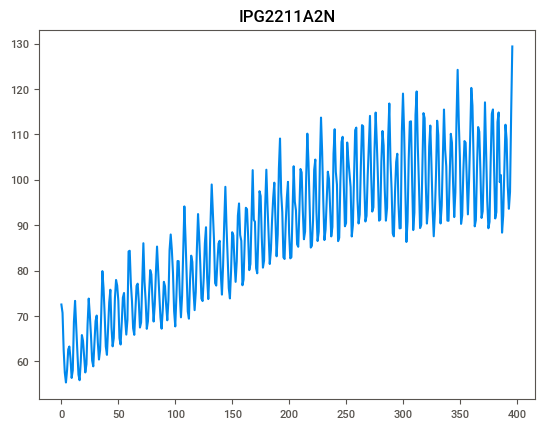

In [130]:
for i, col in enumerate(ep.columns):
    ep[col].plot(fig=plt.figure(i))
    plt.title(col)

plt.show() #this plots the raw variables without differencing it

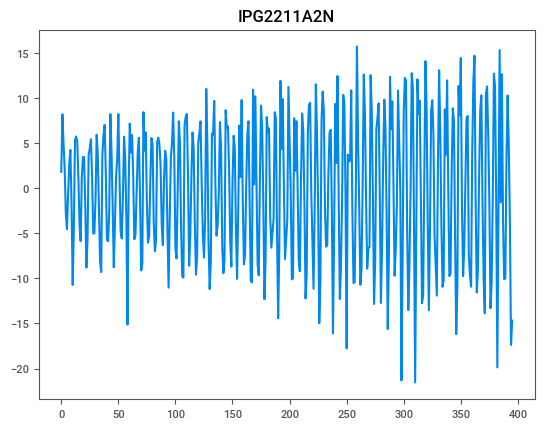

In [131]:
for i, col in enumerate(ep.columns):
    ep[col].diff().plot(fig=plt.figure(i))
    plt.title(col)

plt.show() # df[col].diff() #differenced it once then plots it

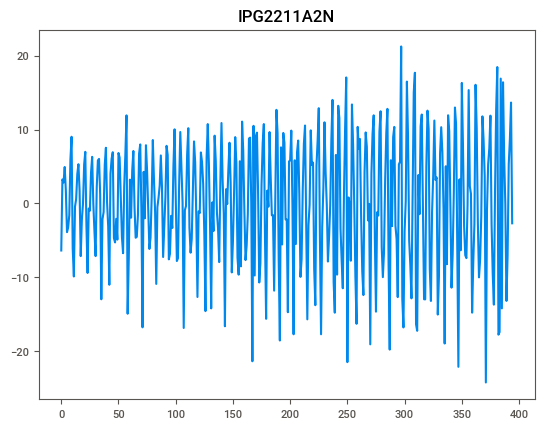

In [132]:
for i, col in enumerate(ep.columns): #differences the columns (column) for the second time and prints the plot
    ep[col].diff().diff().plot(fig=plt.figure(i))
    plt.title(col)

plt.show() #differenced it a second time then plotted it

In [133]:
#the first graph is not great as you can see that there is a predictable trend. The second graph, after it is diffeneced once, is much better as there really isnt a predictable pattern (it is more stationary) but it is not as centered on 0. The final graph, after it was stationed twice is more centered on 0 and has no real predictable pattern (it is stationary), it is coming closer together. 

In [134]:
for i in ep.columns: # I dont have to do the for i in range since there is only 1 column but I still want it so I know for future reference
    print (i)
    print()
    print (stattools.kpss(ep[i].diff().tail(len(ep)-1), regression='ct'))
    print ()

IPG2211A2N

(0.08938456082099676, 0.1, 34, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})



In [135]:
ep[col].diff()

396        NaN
395   -14.6836
394   -17.3853
393    -3.7222
392     5.0017
        ...   
4      -2.7753
3       2.1563
2       4.9788
1       8.2218
0       1.8332
Name: IPG2211A2N, Length: 397, dtype: float64

In [136]:
def acf_pacf (series)-> plt.plot:
    return plot_acf(series), plot_pacf(series) #creates the plots for the ACF and PACF by defining acf_pacf

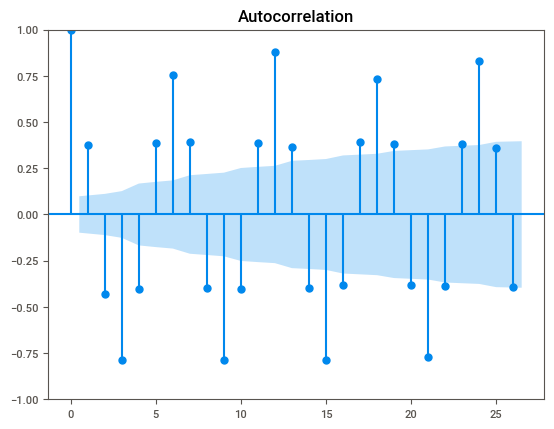

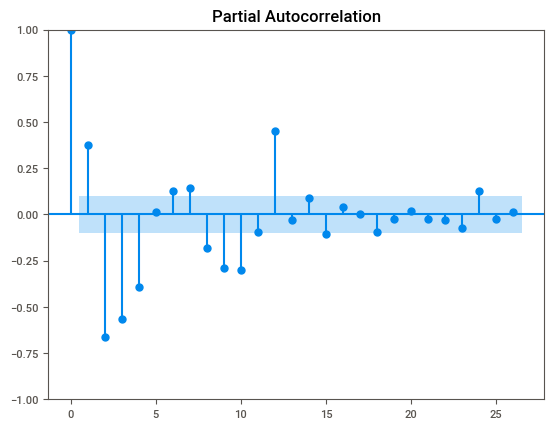

In [161]:
acf_pacf(ep['IPG2211A2N'].diff().tail(len(ep)-1)) # includes -1 because it is differencing it which means the first data point cannot be used. 
print()

In [162]:
# after making the ACF and PACF graphs, the MA order is 25 and the PACF order is 5

In [163]:
# based on two and 4, our final ARIMA order is (5,1,25)

In [164]:
model = sm.tsa.arima.ARIMA(ep['IPG2211A2N'].head(int(0.7*len(ep))), order=(5, 1, 25)) #this fits the model with our ARIMA order of 5,1,25. We use a 70 % training set. 
results = model.fit()

In [165]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             IPG2211A2N   No. Observations:                  277
Model:                ARIMA(5, 1, 25)   Log Likelihood                -689.474
Date:                Mon, 02 Oct 2023   AIC                           1440.948
Time:                        12:13:35   BIC                           1553.180
Sample:                             0   HQIC                          1485.985
                                - 277                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6525      0.528     -1.236      0.216      -1.687       0.382
ar.L2         -0.4494      0.308     -1.459      0.144      -1.053       0.154
ar.L3         -0.8197      0.156     -5.253      0.000      -1.125      -0.514
ar.L4         -0.8272      0.400     -2.067      0.039      -1.612      -0.043
ar.L5         -0.2695      0.430     -0.627      0.531      -1.112       0.573
ma.L1          0.3011      0.522      0.577      0.564      -0.722       1.324
ma.L2         -0.1160      0.180     -0.644      0.520      -0.469       0.237
ma.L3          0.4432      0.178      2.492      0.013       0.095       0.792
ma.L4          0.3289      0.277      1.187      0.235      -0.214       0.872
ma.L5         -0.5514      0.246     -2.238      0.025      -1.034      -0.068
ma.L6         -0.6652      0.395     -1.684      0.092      -1.439       0.109
ma.L7         -0.2998      0.321     -0.934      0.351      -0.929       0.330
ma.L8         -0.3041      0.135     -2.257      0.024      -0.568      -0.040
ma.L9         -0.2562      0.174     -1.469      0.142      -0.598       0.086
ma.L10        -0.0261      0.187     -0.140      0.889      -0.392       0.340
ma.L11         0.1477      0.112      1.320      0.187      -0.072       0.367
ma.L12         0.5904      0.142      4.172      0.000       0.313       0.868
ma.L13         0.1105      0.311      0.355      0.722      -0.499       0.720
ma.L14         0.0688      0.122      0.562      0.574      -0.171       0.309
ma.L15         0.1066      0.129      0.824      0.410      -0.147       0.360
ma.L16        -0.1408      0.126     -1.120      0.263      -0.387       0.106
ma.L17        -0.1898      0.148     -1.282      0.200      -0.480       0.100
ma.L18        -0.2168      0.175     -1.241      0.215      -0.559       0.126
ma.L19        -0.2259      0.130     -1.744      0.081      -0.480       0.028
ma.L20         0.1168      0.177      0.658      0.510      -0.231       0.464
ma.L21         0.2377      0.099      2.413      0.016       0.045       0.431
ma.L22        -0.0148      0.177     -0.084      0.933      -0.361       0.332
ma.L23         0.1161      0.080      1.455      0.146      -0.040       0.272
ma.L24         0.3287      0.099      3.304      0.001       0.134       0.524
ma.L25        -0.0654      0.199     -0.328      0.743      -0.456       0.325
sigma2         8.2207      0.675     12.188      0.000       6.899       9.543
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                44.75
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.22
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

In [166]:
ep['IPG2211A2N_forecast']=results.predict(start = int(0.7*len(ep))+1, end=len(ep) , dynamic=True) #names the forecast as the prediction for test set

In [167]:
# this says how thre trainng set is 70% and we want our test set to start right after it

<Axes: >

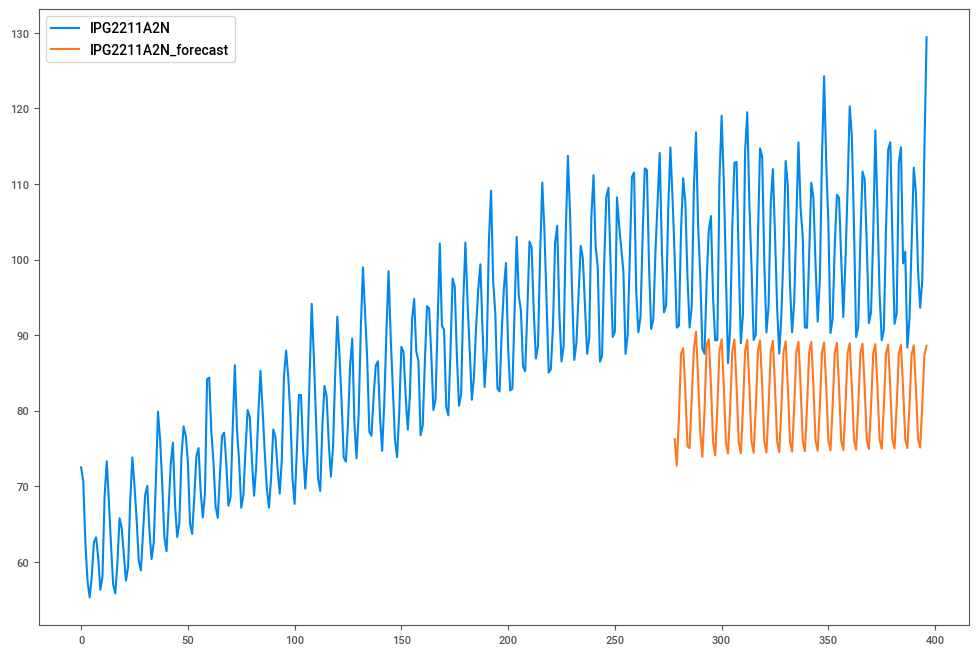

In [168]:
ep[['IPG2211A2N','IPG2211A2N_forecast']].plot(figsize=(12,8)) #creates the plot for the forecast model and the actual model

In [169]:
# This is not a great forecast as it does not line up with the actual data too well. 

In [179]:
mean_absolute_error(ep['IPG2211A2N_forecast'].head(int(0.3*len(ep))),ep['IPG2211A2N'].head(int(0.3*len(ep)))) 
#shows the mean absolute error but uses only the 30% for the forecast, takes out the 70% training

20.1329094948717

In [180]:
mean_squared_error(ep['IPG2211A2N_forecast'].head(int(0.3*len(ep))),ep['IPG2211A2N'].head(int(0.3*len(ep))))
#shows the mean squared error but uses only the 30% for the forecast, takes out the 70% training

447.79605184527355

In [176]:
print(ep.IPG2211A2N_forecast) # this prints out the forecast model for the Energy production

396    88.596930
395    87.475044
394    80.737532
393    75.121360
392    76.255413
         ...    
4            NaN
3            NaN
2            NaN
1            NaN
0            NaN
Name: IPG2211A2N_forecast, Length: 397, dtype: float64


In [178]:
len(ep.IPG2211A2N_forecast) # This says the length of the forecast model

397

In [181]:
mean_absolute_percentage_error(ep['IPG2211A2N_forecast'].head(int(0.3*len(ep))),ep['IPG2211A2N'].head(int(0.3*len(ep))))

0.24549219005945924

In [ ]:
# Overall I do not think that our model is too good. It has the same similar shape of our data as it bounces up 
#and down but it it pretty far below the actual data. So if somoene took a point from our forecasted data and
#compared it to the actual data it looks like it would typically be around 20 points off. This is a lot when the 
#max is around 120 for Energy. That would mean that at the lowest it would be is around 16% off from the actual. 